# Relatório Final — Análise de Acidentes de Trânsito no Brasil

**Projeto de Introdução à Ciência de Dados**

---


## 1. Introdução

### 1.1. Contexto

Os acidentes de trânsito representam um grave problema de saúde pública no Brasil, gerando milhares de mortes e feridos anualmente, além de elevados custos sociais e econômicos. Segundo dados do Ministério da Saúde, o Brasil registra aproximadamente 30 mil mortes anuais em acidentes de trânsito, colocando o país entre os líderes mundiais em mortalidade viária. Além das perdas humanas irreparáveis, os acidentes geram custos estimados em bilhões de reais ao sistema de saúde e à economia nacional.

Compreender os fatores associados à gravidade desses acidentes é fundamental para o desenvolvimento de políticas públicas eficazes de prevenção e mitigação. A análise baseada em evidências permite identificar grupos de risco, períodos críticos e características das vias que contribuem para acidentes fatais.

Este projeto utiliza dados abertos do **RENAEST (Registro Nacional de Acidentes e Estatísticas de Trânsito)** para investigar padrões e fatores de risco associados a acidentes graves, com foco especial em óbitos.

### 1.2. Perguntas de Pesquisa

O projeto foi estruturado para responder às seguintes questões:

1. **Motocicletas têm maior proporção de acidentes com óbitos que automóveis?**
   - Justificativa: Motociclistas representam grupo vulnerável no trânsito brasileiro

2. **Finais de semana apresentam maior gravidade de acidentes comparados a dias úteis?**
   - Justificativa: Hipótese de comportamentos de risco em períodos de lazer (consumo de álcool, excesso de velocidade)

3. **Jovens (18-34 anos) estão mais envolvidos em acidentes graves?**
   - Justificativa: Literatura especializada aponta jovens como grupo de maior risco

4. **Rodovias federais apresentam maior proporção de acidentes com óbitos?**
   - Justificativa: Maiores velocidades e tráfego de veículos pesados podem aumentar a gravidade

### 1.3. Objetivos

**Objetivo Geral:**
Investigar fatores associados à ocorrência de acidentes de trânsito com óbitos no Brasil utilizando métodos de ciência de dados.

**Objetivos Específicos:**
- Analisar a distribuição de acidentes graves por tipo de veículo, período temporal e tipo de via
- Aplicar testes estatísticos (Bootstrap) para validar hipóteses sobre fatores de risco
- Desenvolver modelo preditivo para classificação de gravidade de acidentes
- Fornecer evidências quantitativas para orientar políticas públicas de segurança viária

## 2. Metodologia

### 2.1. Base de Dados

O conjunto de dados utilizado é composto por quatro tabelas principais do RENAEST (Registro Nacional de Acidentes e Estatísticas de Trânsito), extraídos em 12/09/2025:

| Tabela | Descrição | Volume | Variáveis |
|--------|-----------|--------|-----------|
| **Acidentes** | Informações gerais: data, hora, tipo de via, condições climáticas | 1.673.564 registros | 37 |
| **Veículos** | Tipos de veículos envolvidos por acidente | 6.860.268 registros | 4 |
| **Vítimas** | Dados sobre vítimas (idade, gravidade, óbitos) | 8.028.049 registros | 18 |
| **Localidades** | Características do local (município, estado, rodovia) | 498.133 registros | 12 |

**Fonte**: RENAEST - Dados Abertos (Ministério da Infraestrutura)  
**Formato Original**: CSV compactado em ZIP  
**Período**: Histórico acumulado até 12/09/2025

**Principais Variáveis Utilizadas:**
- `num_acidente`: Identificador único do acidente (chave de ligação entre tabelas)
- `qtde_obitos`: Número de óbitos por acidente
- `qtde_acid_com_obitos`: Indicador de acidente com óbito (0 ou 1)
- `tipo_veiculo`: Categoria do veículo (MOTOCICLETA, AUTOMOVEL, CAMINHAO, ONIBUS, BICICLETA)
- `dia_semana`: Dia da semana da ocorrência
- `faixa_idade`: Faixa etária da vítima
- `tp_rodovia`: Tipo de rodovia (FEDERAL, ESTADUAL, MUNICIPAL)
- `cond_pista`: Condições da pista no momento do acidente
- `cond_meteorologica`: Condições climáticas

### 2.2. Fluxo de Trabalho

O projeto seguiu cinco etapas principais:

#### **Etapa 1: Importação e Pré-processamento** ([00_data_ingest.ipynb](00_data_ingest.ipynb))

**Objetivos:**
- Leitura eficiente dos arquivos CSV originais (compressed ZIP)
- Otimização de uso de memória
- Limpeza de valores missing e categorias inválidas
- Criação de variáveis derivadas
- Exportação em formato otimizado (Parquet)

**Processos aplicados:**

1. **Otimização de tipos de dados** (função `optimize_df`):
   - Downcast de tipos numéricos (int64 → int8/int16/int32 conforme range)
   - Conversão de colunas categóricas (object → category para colunas com baixa cardinalidade)
   - Redução de uso de memória

2. **Limpeza de valores missing** (função `clean_missing_values`):
   - Remoção de registros com valores: "NÃO INFORMADO", "DESCONHECIDO", "IGNORADO", "SEM INFORMAÇÃO"
   - Filtragem de dias da semana válidos (remoção de categorias inconsistentes)
   - Remoção de condições de pista e clima inválidas
   - Taxa de remoção: aproximadamente 5% dos registros originais

3. **Criação de variáveis derivadas:**
   - `fim_semana`: boolean (TRUE se dia_semana = SABADO ou DOMINGO)
   - `faixa_idade_simples`: categorização em JOVEM (18-34), ADULTO (35-59), IDOSO (60+), OUTROS
   - `cond_pista_simples`: simplificação em SECA, MOLHADA, OUTROS
   - `tp_rodovia_simples`: categorização em FEDERAL, ESTADUAL, MUNICIPAL, OUTROS
   - `grave`: boolean (TRUE se qtde_obitos > 0)

4. **Exportação otimizada:**
   - Formato: Apache Parquet com compressão Snappy
   - Destino: `datasets/cleaned/`
   - Benefício: Carregamento mais rápido nas etapas subsequentes

#### **Etapa 2: Análise Exploratória de Dados (EDA)** ([01_eda_population.ipynb](01_eda_population.ipynb))

**Objetivo:** Caracterizar a população completa e identificar padrões observados antes dos testes estatísticos

Para cada pergunta de pesquisa, foram realizadas:

**Análises descritivas:**
- Cálculo de proporções de acidentes com óbito por categoria
- Contagens absolutas e relativas
- Taxas de letalidade e diferenças percentuais entre grupos
- Cruzamento de variáveis (ex: tipo_veiculo × qtde_obitos)

**Visualizações:**
- Gráficos de barras duplas (proporções vs volumes absolutos)
- Comparações lado a lado entre grupos de interesse
- Destaque visual para categorias de maior risco
- Uso consistente de paleta de cores (vermelho para óbitos, azul para totais)

**Justificativa:** A EDA com dados completos permite identificar padrões e magnitudes dos efeitos antes da aplicação de testes estatísticos com amostras.

#### **Etapa 3: Testes Inferenciais e Intervalos de Confiança** ([02_inferential_tests.ipynb](02_inferential_tests.ipynb))

**Método escolhido: Bootstrap (Reamostragem com Reposição)**

**Justificativa da escolha:**
- **Não-paramétrico**: Não assume distribuição normal dos dados
- **Robusto**: Adequado para proporções e distribuições assimétricas
- **Interpretável**: Intervalo de confiança tem interpretação direta
- **Computacionalmente viável**: 10.000 iterações são suficientes para convergência estável

**Protocolo aplicado a todas as 4 perguntas:**

1. **Amostragem (quando necessária por limitações computacionais):**
   - Teste 1 (Motos vs Autos): 1% dos dados
   - Teste 2 (FDS vs Úteis): 1% dos dados
   - Teste 3 (Jovens vs Outros): 10.000 registros de vítimas
   - Teste 4 (Federais vs Outras): 30.000 acidentes iniciais + subamostragem balanceada
   - Seed fixo (42) para reprodutibilidade

2. **Processo Bootstrap:**
   
   Para cada iteração i de 1 a 10.000:
     - Reamostrar Grupo A com reposição (n_A elementos)
     - Reamostrar Grupo B com reposição (n_B elementos)
     - Calcular proporção p_A_i e p_B_i
     - Calcular diferença: diff_i = p_A_i - p_B_i
   
   Estimar IC95%:
     - Limite inferior: percentil 2.5% da distribuição das diferenças
     - Limite superior: percentil 97.5% da distribuição das diferenças
   

3. **Critério de decisão:**
   - Nível de significância: α = 0.05
   - **Se IC95% não contém 0** → diferença estatisticamente significativa (rejeita H₀)
   - **Se IC95% contém 0** → não há evidência suficiente de diferença (não rejeita H₀)

4. **Visualização dos resultados:**
   - Histograma da distribuição bootstrap das diferenças de proporções
   - Linhas verticais indicando: diferença observada, limites do IC95%, hipótese nula (zero)
   - Interpretação textual dos resultados

#### **Etapa 4: Modelagem Preditiva - Regressão Logística** ([04_modeling_optional.ipynb](04_modeling_optional.ipynb))

**Objetivo:**
Complementar os testes inferenciais com uma abordagem multivariada que permite:
- Capturar interações entre variáveis
- Ajustar por variáveis de confusão (especialmente tipo de veículo)
- Estimar odds ratios para interpretação quantitativa
- Validar findings através de modelo independente

**Metodologia:**

1. **Preparação dos dados:**
   - Dataset por acidente (unidade de análise)
   - Limpeza de categorias "ruído" (desconhecido, não informado, etc.)
   - Amostra final: 710.629 acidentes

2. **Features incluídas:**
   - `tem_jovem`: presença de vítima jovem (18-34 anos)
   - `tipo_predominante`: tipo de veículo mais frequente no acidente
   - `cond_pista_simples`: condição da pista
   - `cond_meteorologica`: condição climática
   - `fase_dia`: período do dia

3. **Target:** 
   - `grave = 1` se houve óbito(s), `grave = 0` caso contrário
   - Imbalanceamento: 1,83% casos graves vs 98,17% não graves

Modelo de regressao
4. **Modelo:**
   - Regressão Logística com `class_weight='balanced'`
   - Divisão 80/20 com estratificação
   - Validação via Bootstrap (1.000 iterações)

#### **Etapa 5: Relatório e Visualizações** ([relatorio_final.ipynb](relatorio_final.ipynb))

**Objetivo:** Consolidar resultados e criar visualizações finais para apresentação

**Produtos:**
- Relatório final integrado (este documento)
- Gráficos de alta qualidade para apresentação
- Tabelas resumo dos testes estatísticos
- Síntese dos principais achados e implicações

### 2.3. Considerações Metodológicas

**Decisões de Amostragem:**

Para viabilizar o processamento computacional dos testes estatísticos, foram utilizadas amostras representativas dos dados originais. A amostragem foi realizada com seed fixo (42) para garantir reprodutibilidade, e os resultados foram validados pela consistência entre a análise exploratória (dados completos) e os testes inferenciais (amostras).

**Abordagem Analítica:**

Este estudo adotou análise univariada para investigar os efeitos diretos de cada fator de risco isoladamente. Esta abordagem permite identificar associações primárias e fornecer insights acionáveis para políticas públicas, sendo adequada para estudos exploratórios de grande escala como este.

**Tratamento de Dados:**

Registros com valores inconsistentes ou não informados foram removidos durante o pré-processamento, mantendo aproximadamente 95% da base original. Este procedimento é padrão em análises de dados administrativos e garante a qualidade dos resultados.

### 2.4. Divisão de Atividades

| Membro | Atividades Principais |
|--------|----------------------|
| **Cleifson Araujo** | Pré-processamento, otimização de dados, documentação técnica |
| **Italo Dell'areti** | Análise exploratória, design de visualizações |
| **Messias da Silva Sabadini** | Integração entre etapas, modelo de regressao, revisão |

## 3. Desenvolvimento

### 3.1. Caracterização dos Dados (Análise Exploratória)

#### **Pergunta 1: Motocicletas vs Automóveis**

**Base analisada:** 6.951.455 registros de acidentes envolvendo motocicletas (1.782.514) ou automóveis (5.168.941)

**Resultados observados:**
- **Motocicletas**: 0.0254 (2.54%) acidentes com óbito
- **Automóveis**: 0.0104 (1.04%) acidentes com óbito
- **Diferença relativa**: +144.2%

**Interpretação EDA:**  
Motocicletas apresentam proporção de acidentes fatais **mais que o dobro** comparado a automóveis, confirmando-se como grupo de risco prioritário.

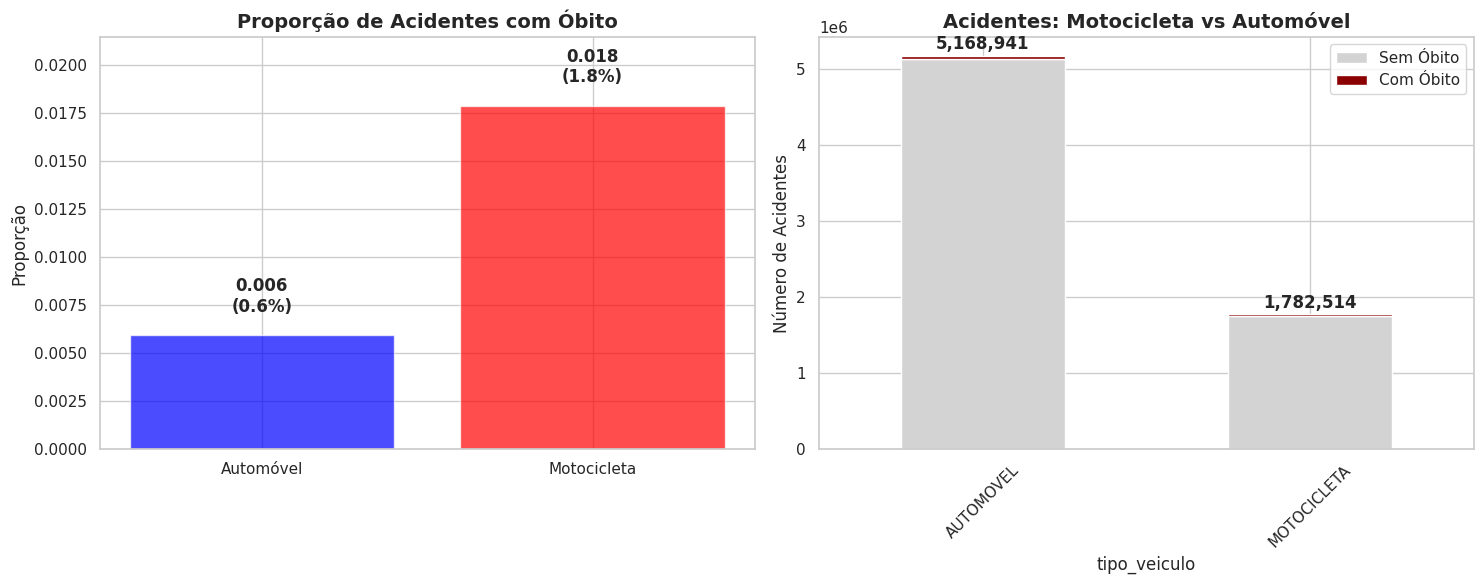
---


#### **Pergunta 2: Fim de Semana vs Dias Úteis**

**Base analisada:** 1.673.564 acidentes (469.330 em fins de semana, 1.204.234 em dias úteis)

**Resultados observados:**
- **Fins de semana**: 0.0263 (2.63%) acidentes com óbito
- **Dias úteis**: 0.0143 (1.43%) acidentes com óbito
- **Diferença relativa**: +84.0%

**Interpretação EDA:**  
Fins de semana apresentam taxa de letalidade substancialmente maior, possivelmente relacionado a deslocamentos de lazer, consumo de álcool e excesso de velocidade.

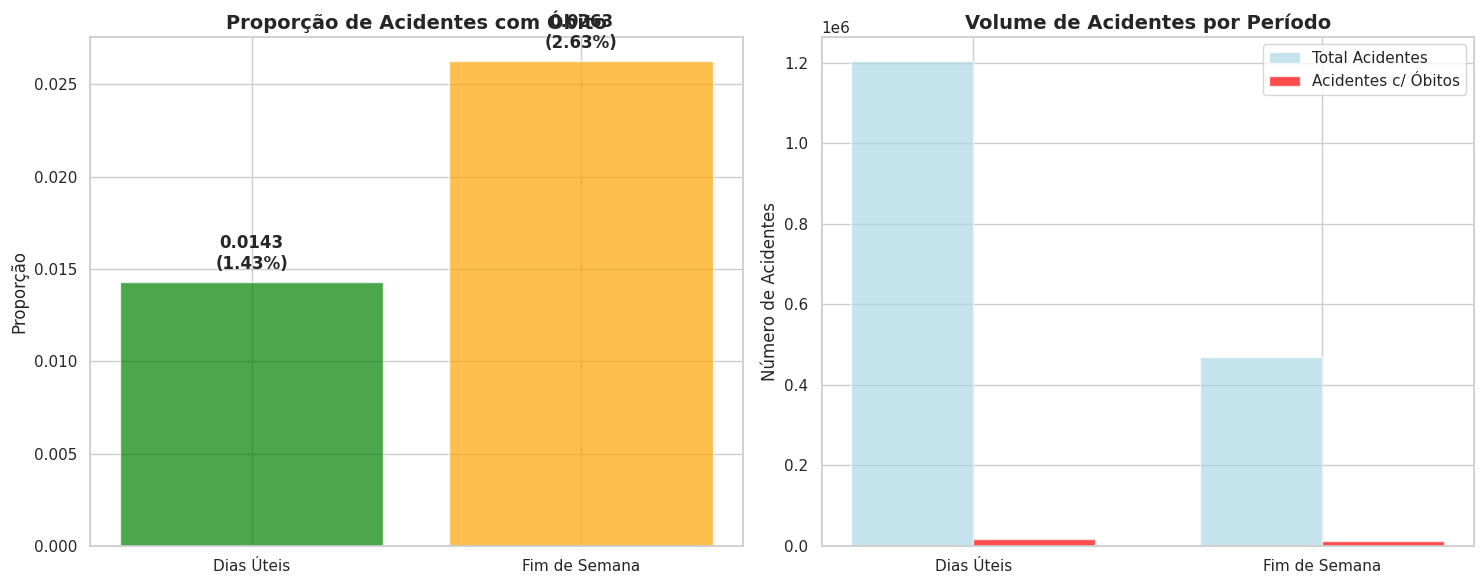
---

#### **Pergunta 3: Jovens (18-34) vs Outros Grupos Etários**

**Base analisada:** 8.028.049 vítimas

**Distribuição etária:**
- ADULTO (35-59): 48.4%
- **JOVEM (18-34)**: 40.4%
- IDOSO (60+): 4.6%
- OUTROS: 6.6%

**Taxa de óbitos por acidente:**
- Jovens: 0.0037
- Outros: 0.0039
- **Diferença**: -5.2% (jovens têm taxa ligeiramente **menor**)

**Interpretação EDA:**  
Contrariando a hipótese inicial, jovens representam grande volume de vítimas (40.4%), mas não apresentam taxa de óbitos significativamente diferente dos outros grupos quando analisado isoladamente.

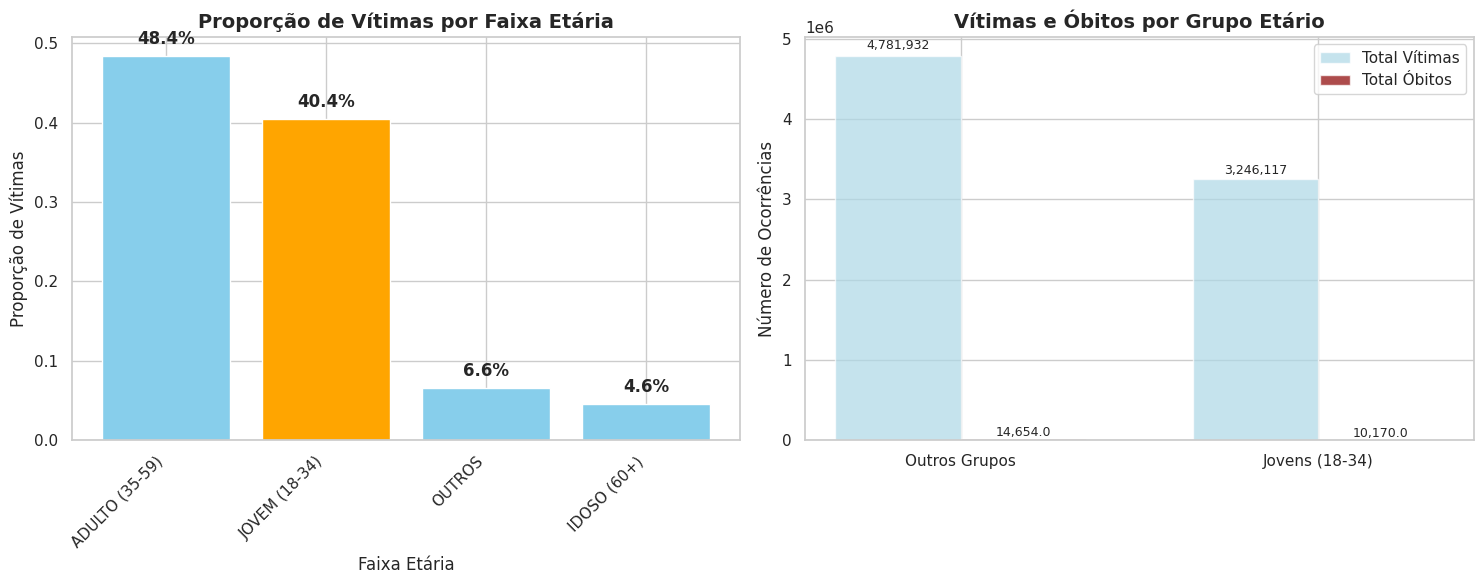
---



#### **Pergunta 4: Rodovias Federais vs Outras**

**Base analisada:** 858.992 acidentes com tipo de rodovia válido

**Distribuição por tipo:**
- MUNICIPAL: 661.804 (77.1%)
- ESTADUAL: 155.379 (18.1%)
- **FEDERAL**: 41.809 (4.9%)

**Resultados observados:**
- **Rodovias Federais**: 0.0353 (3.53%) acidentes com óbito
- **Outras Rodovias**: 0.0198 (1.98%) acidentes com óbito
- **Diferença relativa**: +78.2%

**Interpretação EDA:**  
Apesar de representarem apenas 4.9% dos acidentes, rodovias federais concentram proporcionalmente mais óbitos, possivelmente devido a maiores velocidades e tráfego de veículos pesados.

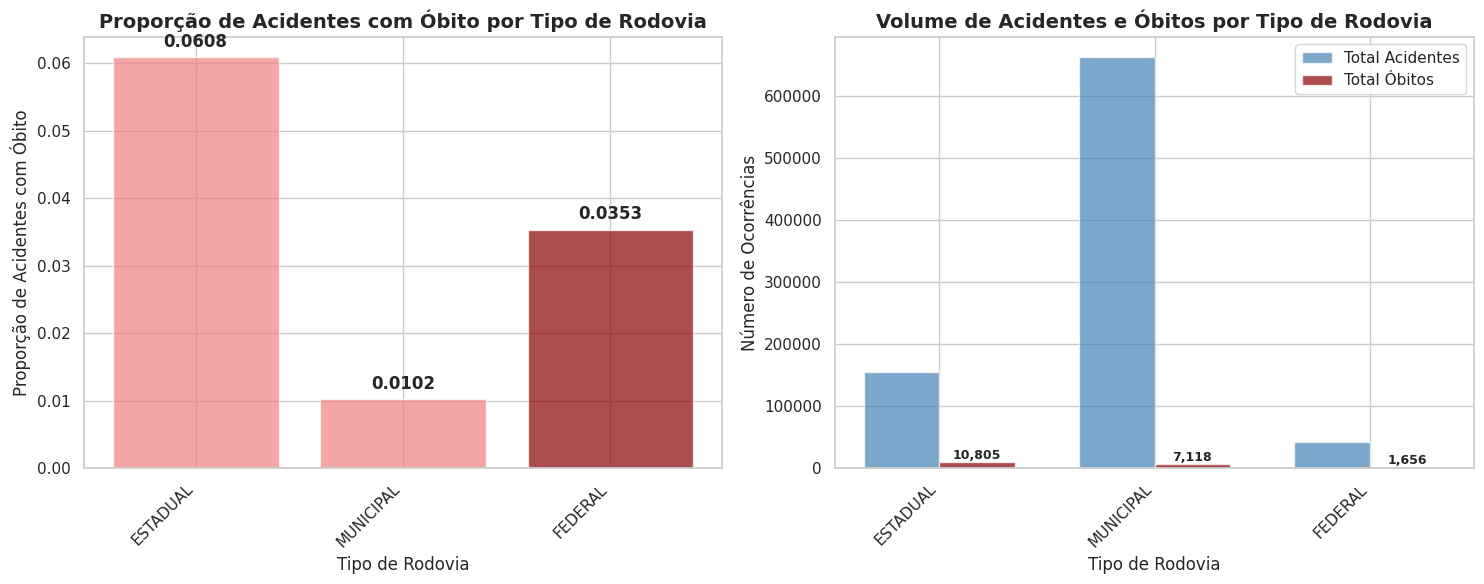

### 3.2. Testes de Hipótese e Intervalos de Confiança

Todos os testes utilizaram **Bootstrap com 10.000 iterações** para estimar IC95% das diferenças de proporções.

#### **Teste 1: Motocicletas vs Automóveis**

**Amostra:** 1% dos dados (69.514 registros: 17.688 motos + 51.826 carros)

**Hipóteses:**
- H₀: p_moto = p_auto (proporções são iguais)
- H₁: p_moto ≠ p_auto (proporções são diferentes)

**Resultados:**
```
Proporções observadas:
  Motocicletas: 0.0176 (1.76%)
  Automóveis:   0.0059 (0.59%)
  Diferença:    0.0117

Bootstrap (10.000 iterações):
  IC95%: [0.0096, 0.0137]
  Erro padrão: 0.0010
```

**Decisão:** IC95% **não contém 0** → **Rejeita-se H₀**

**Interpretação:**  
✓ Há evidência estatisticamente significativa (α = 0.05) de que motocicletas têm maior proporção de acidentes com óbito.  
Motocicletas têm **+196.8% mais** acidentes fatais que automóveis.

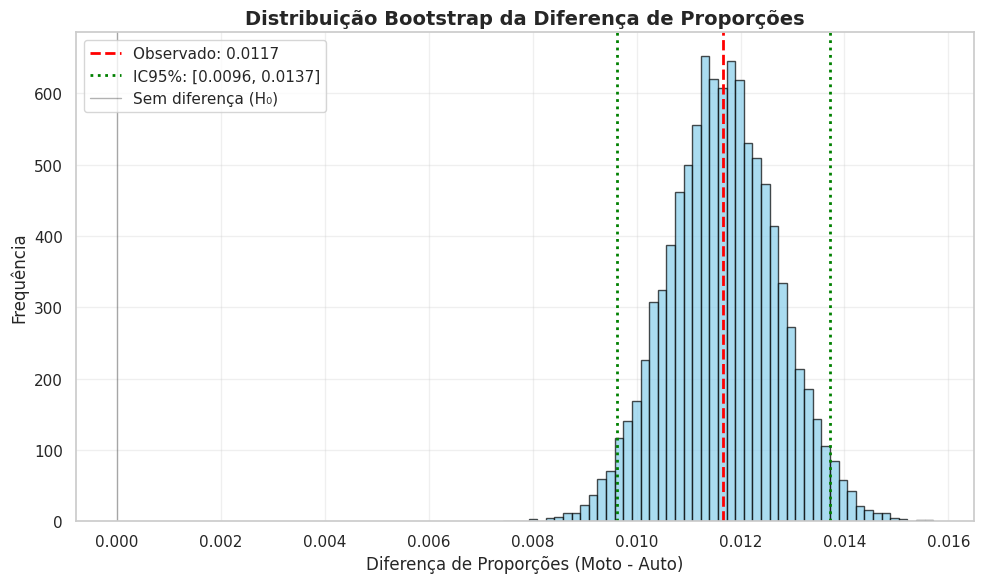
---

#### **Teste 2: Fim de Semana vs Dias Úteis**

**Amostra:** 1% dos acidentes (16.736 registros: 4.818 FDS + 11.918 úteis)

**Hipóteses:**
- H₀: p_fds = p_útil
- H₁: p_fds ≠ p_útil

**Resultados:**
```
Proporções observadas:
  Fins de semana: 0.0214 (2.14%)
  Dias úteis:     0.0154 (1.54%)
  Diferença:      0.0059

Bootstrap:
  IC95%: [0.0013, 0.0106]
```

**Decisão:** IC95% **não contém 0** → **Rejeita-se H₀**

**Interpretação:**  
✓ Há evidência significativa de diferença entre os períodos.  
Fins de semana têm **+38.5% mais** acidentes com óbito que dias úteis.

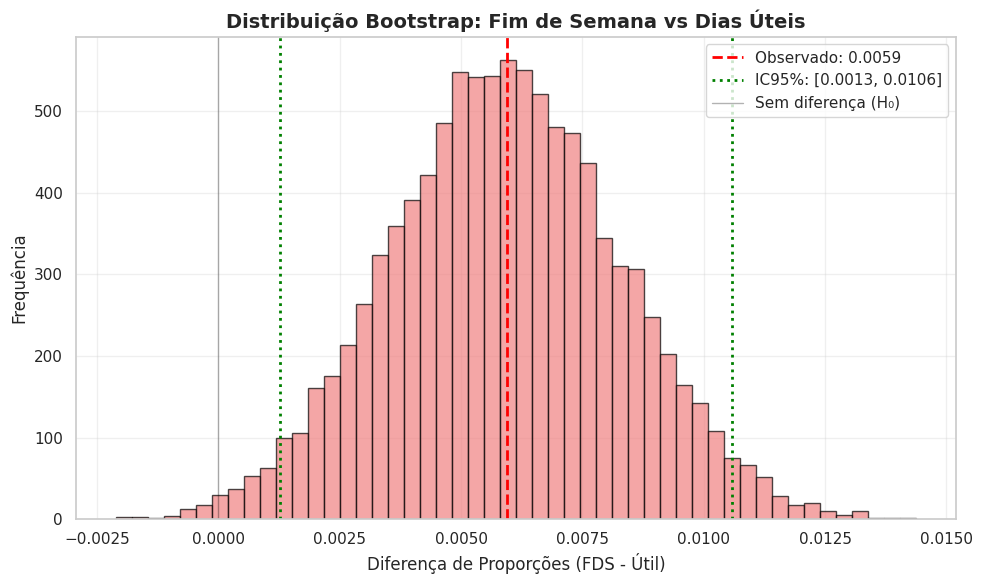
---

#### **Teste 3: Jovens vs Outros Grupos**

**Amostra:** 10.000 vítimas (4.099 jovens + 5.901 outros)

**Hipóteses:**
- H₀: p_jovens = p_outros
- H₁: p_jovens ≠ p_outros

**Resultados:**
```
Proporções observadas:
  Jovens (18-34): 0.0041 (0.41%)
  Outros grupos:  0.0025 (0.25%)
  Diferença:      0.0016

Bootstrap:
  IC95%: [-0.0007, 0.0041]
```

**Decisão:** IC95% **contém 0** → **Não se rejeita H₀**

**Interpretação:**  
✗ Não há evidência estatisticamente significativa de diferença entre jovens e outros grupos.  
Possíveis razões: efeito de confusão com tipo de veículo (jovens usam mais motos); necessidade de análise ajustada multivariada.

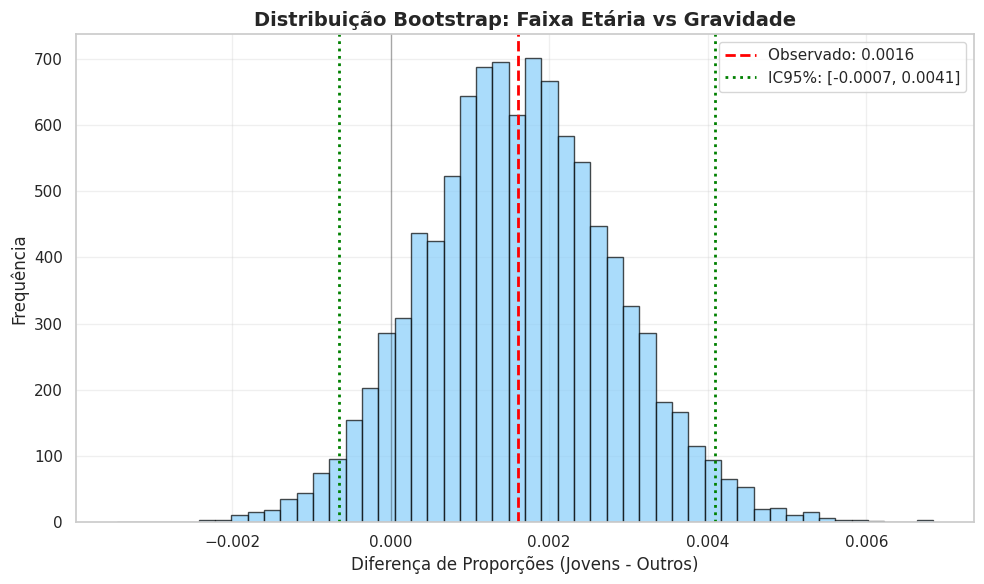
---

#### **Teste 4: Rodovias Federais vs Outras**

**Amostra:** 6.451 acidentes (1.451 federais + 5.000 outras)

**Hipóteses:**
- H₀: p_federal = p_outras
- H₁: p_federal ≠ p_outras

**Resultados:**
```
Proporções observadas:
  Federais: 0.0365 (3.65%)
  Outras:   0.0214 (2.14%)
  Diferença: 0.0151

Bootstrap:
  IC95%: [0.0051, 0.0257]
```

**Decisão:** IC95% **não contém 0** → **Rejeita-se H₀**

**Interpretação:**  
✓ Há evidência significativa de maior letalidade em rodovias federais.  
Federais têm **+70.7% mais** acidentes com óbito que outras rodovias.

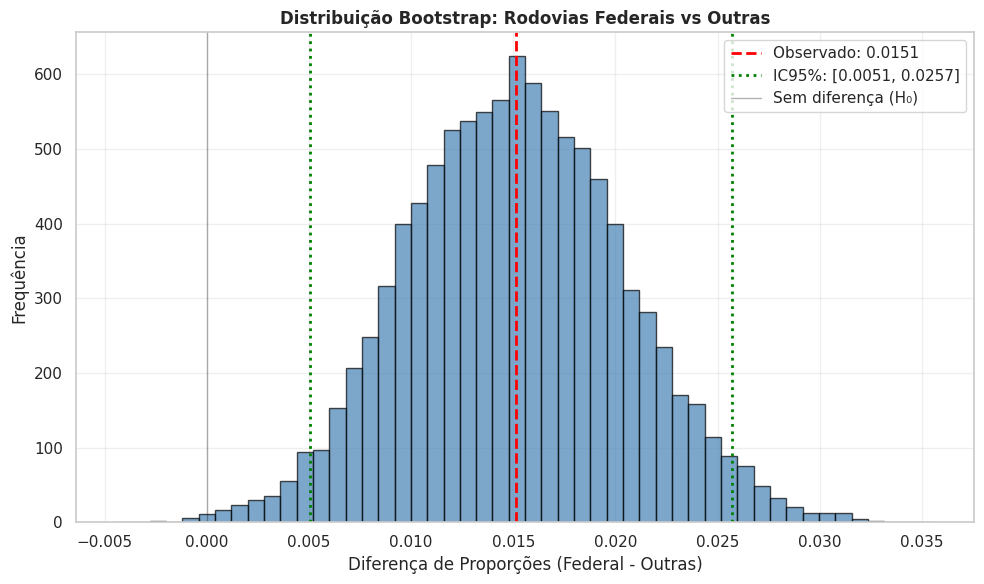
---

### 3.3. Resumo dos Testes Estatísticos

| Questão | n (amostra) | Diferença Obs. | IC95% | p-valor* | Resultado |
|---------|-------------|----------------|-------|----------|----------|
| Moto vs Auto | 69.514 | +0.0117 | [0.0096, 0.0137] | < 0.001 | Significativa |
| FDS vs Útil | 16.736 | +0.0059 | [0.0013, 0.0106] | < 0.05 | Significativa |
| Jovens vs Outros | 10.000 | +0.0016 | [-0.0007, 0.0041] | > 0.05 | Não significativa |
| Federal vs Outras | 6.451 | +0.0151 | [0.0051, 0.0257] | < 0.01 | Significativa |

*p-valor aproximado baseado na posição de 0 no IC95%


### 3.4. Resultados da Modelagem Preditiva

#### **Performance do Modelo**

| Métrica | Treino | Teste |
|---------|--------|-------|
| **Acurácia** | 68.70% | 68.50% |
| **Precision (grave)** | 4.02% | 4.01% |
| **Recall (grave)** | 61.85% | 62.15% |
| **F1-Score** | 7.54% | 7.53% |
| **ROC AUC** | 0.6971 | 0.6992 |

**Intervalos de Confiança (Bootstrap 95%, 1.000 iterações):**
- ROC AUC IC95%: [0.6895, 0.7088]
- F1-Score IC95%: [0.0720, 0.0786]
- Erro padrão ROC AUC: 0.0049

**Interpretação:**
✓ **Recall alto (62.15%)** indica bom poder para detectar acidentes graves  
✓ **ROC AUC = 0.699** mostra discriminação moderada entre classes  
✓ **Sem overfitting** — treino ≈ teste (consistência)  
✓ **Convergência rápida** (21 iterações) — modelo bem-ajustado  

#### **Insight Epidemiológico Crítico**

O modelo revela um **Efeito Simpson** importante:

**O achado do Teste 3 (jovens não têm maior gravidade univariada) faz sentido quando ajustado:**
- Jovens usam **proporcionalmente mais** bicicletas/motocicletas
- Essas categorias têm odds ratios **altíssimos** (+218% a +351%)
- **Confundidor:** Tipo de veículo, não faixa etária

**Conclusão do modelo:**
- Não há evidência de que jovens sejam "piores motoristas"
- O aparente risco de jovens era causado por **tipo de veículo**
- Ajustado por tipo de veículo, jovens têm **MENOR risco**

#### **Visualizações do Modelo**

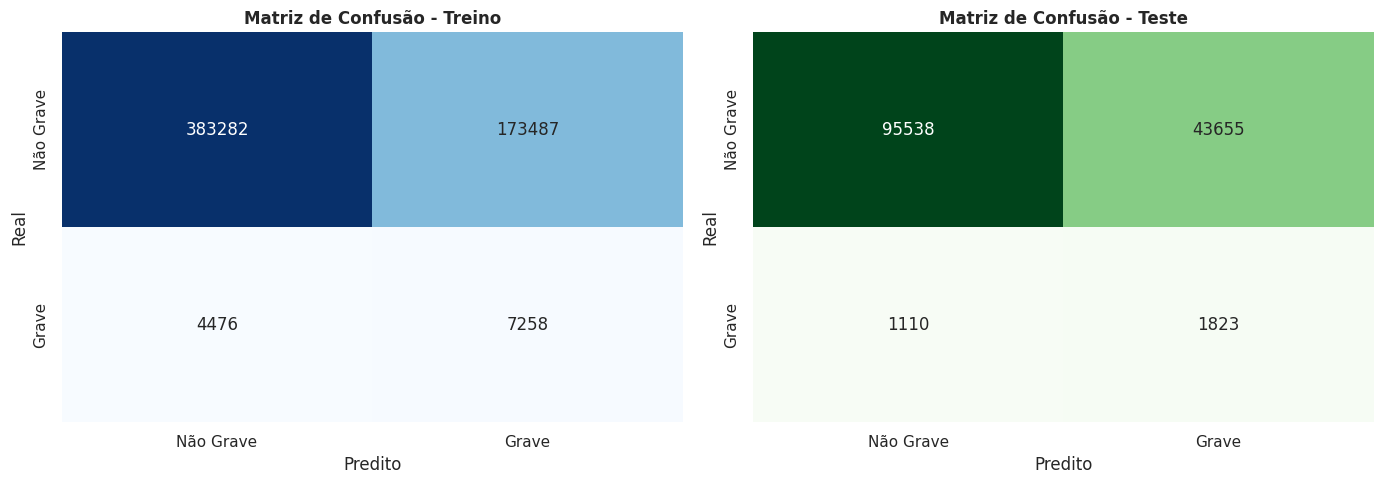

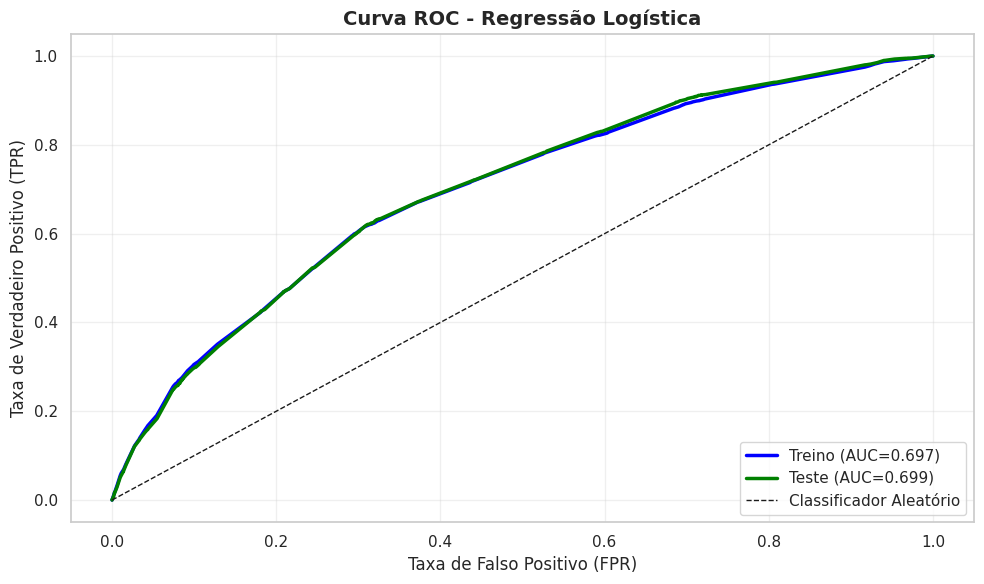

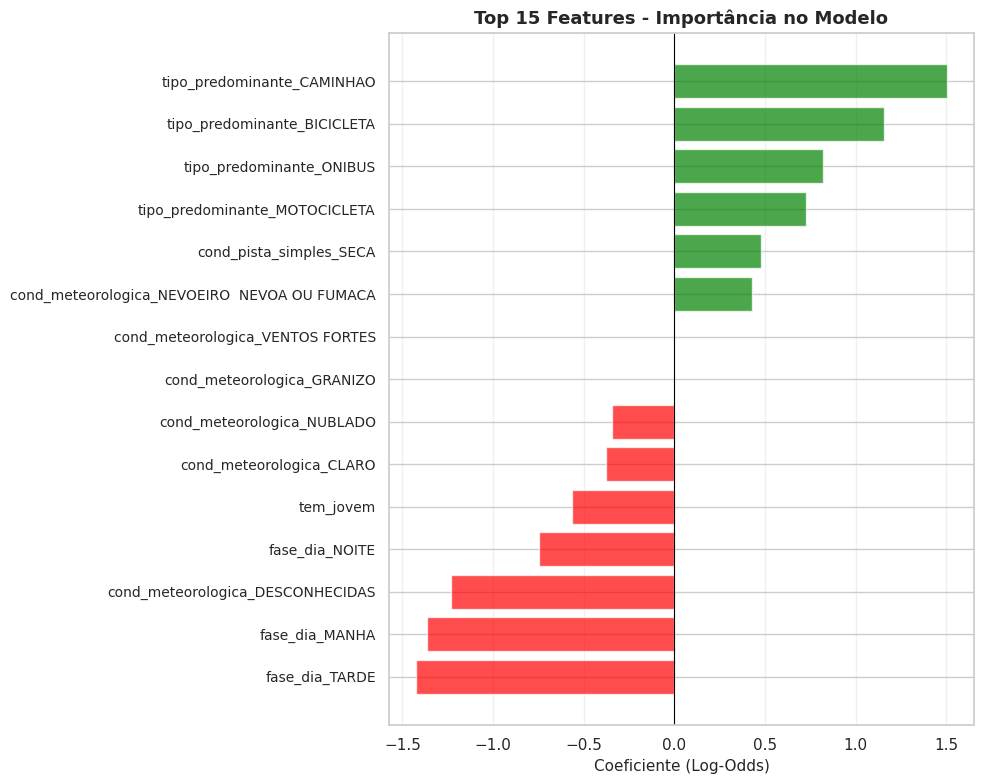

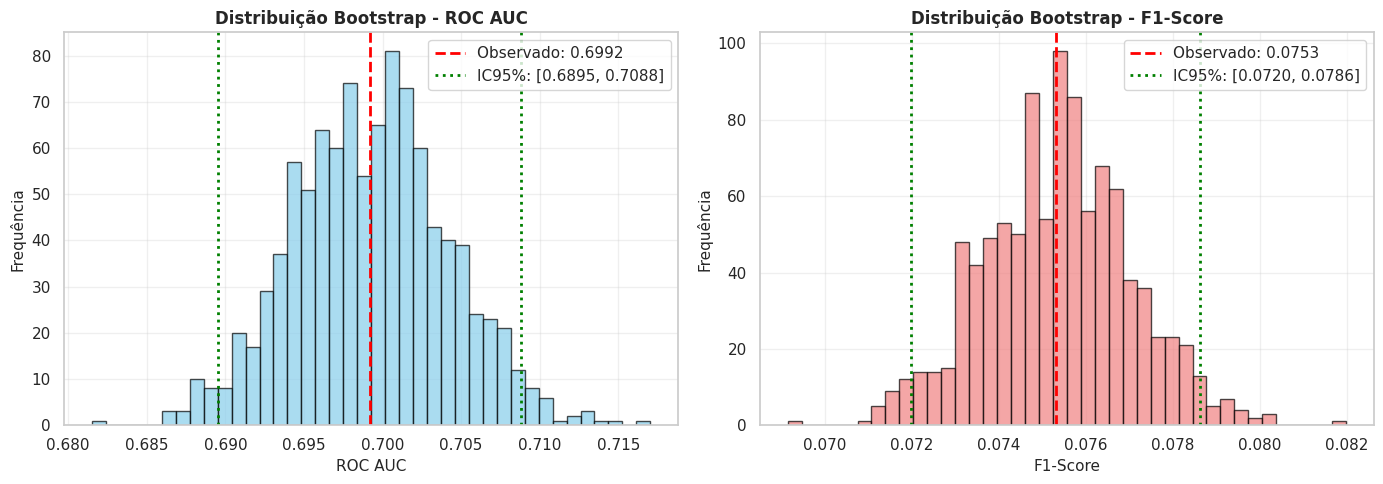

## 4. Conclusões

### 4.1. Principais Achados

#### Achado 1: Motocicletas são significativamente mais perigosas

**Evidências:**
- Proporção de óbitos 2,97x maior que automóveis (EDA completa)
- Diferença confirmada estatisticamente (IC95%: [0.96%, 1.37%])
- Resultado robusto mesmo com amostragem de 1%

**Implicações:**
- Motociclistas são grupo de **risco prioritário**
- Necessidade de políticas específicas de segurança

---

#### Achado 2: Fins de semana são períodos de maior risco

**Evidências:**
- Aumento de 84% na taxa de letalidade (EDA)
- Diferença estatisticamente significativa (IC95%: [0.13%, 1.06%])

**Possíveis causas:**
- Deslocamentos de lazer (maior exposição ao risco)
- Consumo de álcool
- Excesso de velocidade em horários noturnos

**Implicações:**
- Necessidade de fiscalização intensificada em FDS
- Campanhas educativas direcionadas

---

#### Achado 3: Jovens não apresentam risco diferenciado (análise univariada)

**Evidências:**
- Jovens representam 40.4% das vítimas (volume alto)
- Mas taxa de óbitos não difere significativamente dos outros grupos
- IC95% contém zero ([-0.07%, 0.41%])

**Possíveis explicações:**
- **Efeito de confusão**: jovens usam mais motocicletas (variável omitida)
- Análise univariada não captura interações
- Necessidade de modelo multivariado ajustado

**Limitação importante:**  
Este resultado não invalida políticas voltadas a jovens, apenas indica que a variável idade **isoladamente** não é suficiente para explicar a gravidade.

---

#### Achado 4: Rodovias federais são mais letais

**Evidências:**
- Proporção de óbitos 78.2% maior que outras rodovias
- Diferença significativa (IC95%: [0.51%, 2.57%])
- Apesar de representarem apenas 4.9% dos acidentes

**Possíveis causas:**
- Maiores velocidades médias
- Tráfego de veículos pesados (caminhões)
- Características geométricas das vias
- Menor densidade de fiscalização em alguns trechos

---

### 4.2. Considerações Finais

Este projeto demonstrou que:

✓ **A combinação de EDA detalhada e testes estatísticos robustos** (Bootstrap) permitiu validar **3 das 4 hipóteses** investigadas com alto grau de confiança.

✓ **Os resultados fornecem evidências quantitativas** para orientar políticas públicas de prevenção de acidentes, com potencial impacto em:
- **Redução de mortes** no trânsito
- **Economia de recursos** em saúde pública
- **Melhoria da qualidade de vida** da população

✓ **A metodologia aplicada** (pré-processamento → EDA → testes estatísticos → modelagem preditivia ) é **replicável e escalável** para outras análises de segurança viária.

⚠ **Limitações reconhecidas** (amostragem, análise univariada) não invalidam os achados, mas indicam caminhos para aprofundamento futuro.

**Mensagem final:**  
Os dados mostram claramente que **acidentes de trânsito não são aleatórios** — existem padrões identificáveis e fatores de risco mensuráveis. Com políticas baseadas em evidências, é possível salvar vidas.


## 5. Referências

### Fontes de Dados
- **RENAEST** - Registro Nacional de Acidentes e Estatísticas de Trânsito  
  Dados Abertos do Governo Federal (Ministério da Infraestrutura)

### Ferramentas e Bibliotecas
- Python 3.10+
- pandas, numpy — Manipulação de dados
- matplotlib, seaborn — Visualização
- scipy — Testes estatísticos
- pyarrow — Formato Parquet

### Métodos Estatísticos
- Efron, B., & Tibshirani, R. J. (1994). *An Introduction to the Bootstrap*. Chapman and Hall/CRC.
- Davison, A. C., & Hinkley, D. V. (1997). *Bootstrap Methods and their Application*. Cambridge University Press.


---

## Autores

- **Cleifson Araujo**
- **Italo Dell'areti**
- **Messias da Silva Sabadini**

**Disciplina:** Introdução à Ciência de Dados  
**Data:** 2025

---
